# Assignment 2: Transformer Architecture Exercise
Use this notebook as a starting point and expand on your understanding of transformer models by completing the following structured tasks. You are encouraged to experiment, analyze, and critically reflect on your findings in your report.

## Part 1: Model Training & Implementation
### 1. Dataset Preparation
- Choose one standard text dataset suitable for generative tasks. Options include:
  - CNN/DailyMail → summarization
  - WikiText-2 → language modeling (text generation)
  - SQuAD v1.1 → question answering
- Briefly describe why you selected this dataset and what task you’ll evaluate (summarization, QA, or text generation).
- Show how you preprocessed the data (tokenization, train/val split, max length, etc.).


In [35]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
    AutoModelForSeq2SeqLM,
    DataCollatorForLanguageModeling,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
)
import evaluate
from transformers import logging
from tqdm import tqdm
import numpy as np

# Silence warnings for cleaner output
logging.set_verbosity_error()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [36]:
# Load the wikitext-2 dataset
dataset = load_dataset("wikitext", "wikitext-2-v1")

# Filter out empty texts (WikiText-2 has many empty lines)
def filter_empty(example):
    return len(example["text"].strip()) > 0

dataset["train"] = dataset["train"].filter(filter_empty)
dataset["validation"] = dataset["validation"].filter(filter_empty)

# For quick experimentation, take a small subset
train_size = 500
val_size = 100
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(train_size))
small_val_dataset = dataset["validation"].shuffle(seed=42).select(range(val_size))

print("Dataset splits:", dataset.keys())
print("Example training record:", small_train_dataset[0])

Dataset splits: dict_keys(['test', 'train', 'validation'])
Example training record: {'text': " The ship 's primary armament consisted of four 30 @.@ 5 cm ( 12 in ) 45 @-@ caliber guns in two twin gun turrets . This was augmented by a heavy secondary battery of eight 24 cm ( 9 @.@ 4 in ) guns in four wing turrets . The tertiary battery consisted of twenty 10 cm L / 50 guns in casemated single mounts , four 47 mm ( 1 @.@ 85 in ) L / 44 and one 47 mm L / 33 quick @-@ firing guns . Furthermore , the ship 's boats were equipped with two 66 mm ( 2 @.@ 6 in ) landing guns for operations shore . Three 45 cm ( 17 @.@ 7 in ) torpedo tubes were also carried , one on each broadside and one in the stern . \n"}



### 2. Model Implementation

Implement and train the following:
- Decoder-only model (GPT-style): e.g., GPT-2 small from Hugging Face.
- Encoder-only model (BERT-style): e.g., BERT-base, used for masked-language-modeling or extractive QA/summarization.
- Encoder-decoder model (T5-style): e.g., T5-small, trained for the same dataset/task as the other two.


#### Decoder only model: GPT-2

In [37]:
# Load tokenizer and model for GPT-2
gpt2_model_name = "gpt2"
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)

In [38]:
# Add a padding token (GPT-2 does not have one)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

In [39]:
# Define the preprocessing function for GPT-2
def preprocess_gpt2(examples):
    
    outputs = gpt2_tokenizer(
        examples["text"],           
        max_length=512,
        truncation=True,
        padding="max_length",
        return_tensors=None
    )

    outputs["labels"] = outputs["input_ids"].copy()
    
    return outputs

# Apply preprocessing to the small datasets
train_gpt2 = small_train_dataset.map(preprocess_gpt2, batched=True, remove_columns=dataset["train"].column_names)
val_gpt2 = small_val_dataset.map(preprocess_gpt2, batched=True, remove_columns=dataset["validation"].column_names)

print("Sample tokenized GPT-2 input:")
print(gpt2_tokenizer.decode(train_gpt2[0]["input_ids"][:100]))

Sample tokenized GPT-2 input:
 The ship 's primary armament consisted of four 30 @.@ 5 cm ( 12 in ) 45 @-@ caliber guns in two twin gun turrets . This was augmented by a heavy secondary battery of eight 24 cm ( 9 @.@ 4 in ) guns in four wing turrets . The tertiary battery consisted of twenty 10 cm L / 50 guns in casemated single mounts , four 47 mm ( 1 @.@ 85 in ) L / 44 and one 47 mm L / 33 quick


In [40]:
print("Input IDs and Labels dimensions for first 10 samples:")
for i in range(10):
    print(f"Sample {i}: Input IDs length = {len(train_gpt2[i]['input_ids'])}, Labels length = {len(train_gpt2[i]['labels'])}")

Input IDs and Labels dimensions for first 10 samples:
Sample 0: Input IDs length = 512, Labels length = 512
Sample 1: Input IDs length = 512, Labels length = 512
Sample 2: Input IDs length = 512, Labels length = 512
Sample 3: Input IDs length = 512, Labels length = 512
Sample 4: Input IDs length = 512, Labels length = 512
Sample 5: Input IDs length = 512, Labels length = 512
Sample 6: Input IDs length = 512, Labels length = 512
Sample 7: Input IDs length = 512, Labels length = 512
Sample 8: Input IDs length = 512, Labels length = 512
Sample 9: Input IDs length = 512, Labels length = 512


In [41]:
# Define data collator
data_collator_gpt2 = DataCollatorForLanguageModeling(tokenizer=gpt2_tokenizer, mlm=False)

# Load the GPT-2 model
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_model_name)

# Training arguments
training_args_gpt2 = TrainingArguments(
    output_dir="./gpt2-summarization",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=4,
    fp16=torch.cuda.is_available(),
    report_to=[],  # disable logging to wandb
)

# Create Trainer for GPT-2
trainer_gpt2 = Trainer(
    model=gpt2_model,
    args=training_args_gpt2,
    train_dataset=train_gpt2,
    eval_dataset=val_gpt2,
    data_collator=data_collator_gpt2,
    )

# Uncomment the line below to train; training can take several minutes even on small subsets
trainer_gpt2.train()

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


{'train_runtime': '28.35', 'train_samples_per_second': '17.64', 'train_steps_per_second': '2.222', 'train_loss': '3.815', 'epoch': '1'}


TrainOutput(global_step=63, training_loss=3.8149346245659723, metrics={'train_runtime': 28.3518, 'train_samples_per_second': 17.636, 'train_steps_per_second': 2.222, 'train_loss': 3.8149346245659723, 'epoch': 1.0})

#### Encoder-only model: BERT

In [42]:
# Load tokenizer and model for BERT
bert_model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

In [43]:

# Define preprocessing

def preprocess_bert(examples):
    
    model_inputs = bert_tokenizer(
        examples["text"], 
        max_length=512, 
        truncation=True,
        padding="max_length"  
    )
    return model_inputs

train_bert = small_train_dataset.map(preprocess_bert, batched=True, remove_columns=dataset["train"].column_names)
val_bert = small_val_dataset.map(preprocess_bert, batched=True, remove_columns=dataset["validation"].column_names)

# Data collator with MLM
mlm_probability = 0.15
data_collator_bert = DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, mlm=True, mlm_probability=mlm_probability)

# Load BERT model
bert_model = AutoModelForMaskedLM.from_pretrained(bert_model_name)

# Training arguments for BERT
training_args_bert = TrainingArguments(
    output_dir="./bert-mlm",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=1,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_bert,
    eval_dataset=val_bert,
    data_collator=data_collator_bert,
)

# Uncomment the line below to train the BERT model
trainer_bert.train()


Loading weights: 100%|██████████| 202/202 [00:00<00:00, 967.73it/s, Materializing param=cls.predictions.transform.dense.weight]                 


{'loss': '2.046', 'grad_norm': '30.5', 'learning_rate': '1.733e-05', 'epoch': '0.8'}
{'eval_loss': '1.76', 'eval_runtime': '1.225', 'eval_samples_per_second': '81.62', 'eval_steps_per_second': '20.41', 'epoch': '0.8'}


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


{'train_runtime': '22.24', 'train_samples_per_second': '22.48', 'train_steps_per_second': '5.619', 'train_loss': '2.041', 'epoch': '1'}


TrainOutput(global_step=125, training_loss=2.041166320800781, metrics={'train_runtime': 22.2444, 'train_samples_per_second': 22.478, 'train_steps_per_second': 5.619, 'train_loss': 2.041166320800781, 'epoch': 1.0})

#### T5

In [44]:
# Load T5 tokenizer and model
t5_model_name = "t5-small"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)

In [45]:
# T5 preprocessing for language modeling
def preprocess_t5(examples):   

    inputs = ["generate: " + text for text in examples["text"]]
    
    # Tokenize inputs
    model_inputs = t5_tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    
    # Tokenize targets
    labels = t5_tokenizer(
        examples["text"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing
train_t5 = small_train_dataset.map(preprocess_t5, batched=True, remove_columns=dataset["train"].column_names)
val_t5 = small_val_dataset.map(preprocess_t5, batched=True, remove_columns=dataset["validation"].column_names)


print("Sample T5 input:")
print("Input:", t5_tokenizer.decode(train_t5[0]["input_ids"][:50]))
print("Label:", t5_tokenizer.decode(train_t5[0]["labels"][:50]))

# Data collator for T5
data_collator_t5 = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer, model=t5_model_name)

# Load T5 model
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_name)

# Training arguments for T5
training_args_t5 = TrainingArguments(
    output_dir="./t5-language-modeling",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=2,
    fp16=torch.cuda.is_available(),
    report_to=[],     
)

# Create Trainer for T5
trainer_t5 = Trainer(
    model=t5_model,
    args=training_args_t5,
    train_dataset=train_t5,
    eval_dataset=val_t5,
    data_collator=data_collator_t5,
)

# Train the T5 model
trainer_t5.train()

Sample T5 input:
Input: generate: The ship's primary armament consisted of four 30 @.@ 5 cm ( 12 in ) 45 @-@ caliber guns in two twin gun turrets. This was augmented by 
Label: The ship's primary armament consisted of four 30 @.@ 5 cm ( 12 in ) 45 @-@ caliber guns in two twin gun turrets. This was augmented by a heavy


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


{'train_runtime': '28.55', 'train_samples_per_second': '17.52', 'train_steps_per_second': '2.207', 'train_loss': '8.763', 'epoch': '1'}


TrainOutput(global_step=63, training_loss=8.763131277901786, metrics={'train_runtime': 28.5467, 'train_samples_per_second': 17.515, 'train_steps_per_second': 2.207, 'train_loss': 8.763131277901786, 'epoch': 1.0})


### 3. Training Documentation

- Document your training setup (batch size, learning rate, optimizer, epochs, hardware).
- Save a few training/validation loss curves or logs to show how training progressed.
- Mention any difficulties you faced and how you addressed them (e.g., memory limits, convergence).


In [47]:
# save the model

# Save GPT-2 model and tokenizer
gpt2_model.save_pretrained("./assignment2/gpt2-language-modeling")
gpt2_tokenizer.save_pretrained("./assignment2/gpt2-language-modeling")

# Save BERT model and tokenizer
bert_model.save_pretrained("./assignment2/bert-mlm")
bert_tokenizer.save_pretrained("./assignment2/bert-mlm")

# Save T5 model and tokenizer
t5_model.save_pretrained("./assignment2/t5-language-modeling")
t5_tokenizer.save_pretrained("./assignment2/t5-language-modeling")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


('./assignment2/t5-language-modeling\\tokenizer_config.json',
 './assignment2/t5-language-modeling\\tokenizer.json')


## Part 2: Evaluation & Analysis

### 4. Performance Evaluation

- Evaluate all three models on the same task.
- Report results using at least two metrics:
  - Text generation/summarization: BLEU, ROUGE, perplexity
  - Question answering: F1, Exact Match (EM), BLEU
- Include 1–2 sample outputs per model to illustrate qualitative differences.


In [48]:
# Load evaluation metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

#### Gpt-2

In [49]:
# Test prompts for evaluation
test_prompts = [
    "The history of artificial intelligence",
    "In the field of computer science,",
    "Natural language processing is",
    "Machine learning algorithms can",
    "The development of neural networks",
]

# Reference texts (ground truth for comparison)
reference_texts = [
    "The history of artificial intelligence began in the 1950s with the development of early computing systems and the Turing test.",
    "In the field of computer science, algorithms and data structures form the foundation of software engineering.",
    "Natural language processing is a subfield of artificial intelligence focused on enabling computers to understand human language.",
    "Machine learning algorithms can identify patterns in data and make predictions based on historical information.",
    "The development of neural networks has revolutionized artificial intelligence by enabling deep learning models.",
]

In [50]:
# Load saved GPT-2 model
gpt2_model_eval = AutoModelForCausalLM.from_pretrained("./assignment2/gpt2-language-modeling")
gpt2_tokenizer_eval = AutoTokenizer.from_pretrained("./assignment2/gpt2-language-modeling")

# Calculate perplexity for GPT-2
gpt2_perplexity = calculate_perplexity(gpt2_model_eval, val_gpt2, gpt2_tokenizer_eval, device, max_samples=50)
print(f"\nGPT-2 Perplexity: {gpt2_perplexity:.2f}")

# Generate text samples
gpt2_generated = generate_text_samples(gpt2_model_eval, gpt2_tokenizer_eval, test_prompts, device)

# Calculate BLEU and ROUGE
gpt2_bleu = bleu_metric.compute(predictions=gpt2_generated, references=[[ref] for ref in reference_texts])
gpt2_rouge = rouge_metric.compute(predictions=gpt2_generated, references=reference_texts)

print(f"\nGPT-2 BLEU Score: {gpt2_bleu['bleu']:.4f}")
print(f"GPT-2 ROUGE-1: {gpt2_rouge['rouge1']:.4f}")
print(f"GPT-2 ROUGE-2: {gpt2_rouge['rouge2']:.4f}")
print(f"GPT-2 ROUGE-L: {gpt2_rouge['rougeL']:.4f}")


Calculating perplexity: 100%|██████████| 50/50 [00:01<00:00, 32.18it/s]



GPT-2 Perplexity: 2896.78

GPT-2 BLEU Score: 0.0476
GPT-2 ROUGE-1: 0.1816
GPT-2 ROUGE-2: 0.0950
GPT-2 ROUGE-L: 0.1738


In [51]:
print("\n--- Sample Outputs from GPT-2 ---")
for i in range(2):
    print(f"\nPrompt: '{test_prompts[i]}'")
    print(f"Generated: {gpt2_generated[i]}")


--- Sample Outputs from GPT-2 ---

Prompt: 'The history of artificial intelligence'
Generated: The history of artificial intelligence is a series of controversies and controversies that have dogged the field for decades. In the early 1990s, the United States government was accused of using artificial intelligences to help solve problems such as race relations, terrorism and poverty. The government argued that such artificial systems could help the government improve its public relations efforts and would make the system more efficient. However, critics of the program claimed that the artificial learning system was too complex and that it would require human workers to work in a

Prompt: 'In the field of computer science,'
Generated: In the field of computer science, researchers have often used the term "hard science" to describe the areas of interest most often identified by computer scientists as computer fields . In this context , "core computer scientific fields" are areas such as 

#### Bert

In [52]:

# For BERT, we'll just calculate perplexity since it's not designed for generation
bert_model_eval = AutoModelForMaskedLM.from_pretrained("./assignment2/bert-mlm")
bert_tokenizer_eval = AutoTokenizer.from_pretrained("./assignment2/bert-mlm")


Loading weights: 100%|██████████| 202/202 [00:00<00:00, 841.26it/s, Materializing param=cls.predictions.transform.dense.weight]                 


#### T5

In [53]:
# Load saved T5 model
t5_model_eval = AutoModelForSeq2SeqLM.from_pretrained("./assignment2/t5-language-modeling")
t5_tokenizer_eval = AutoTokenizer.from_pretrained("./assignment2/t5-language-modeling")

Loading weights: 100%|██████████| 131/131 [00:00<00:00, 828.62it/s, Materializing param=shared.weight]                                                      


In [54]:
# Calculate perplexity for T5
t5_perplexity = calculate_perplexity(t5_model_eval, val_t5, t5_tokenizer_eval, device, max_samples=50)
print(f"\nT5 Perplexity: {t5_perplexity:.2f}")

# Generate text samples
t5_generated = generate_t5_text(t5_model_eval, t5_tokenizer_eval, test_prompts, device)

# Calculate BLEU and ROUGE
t5_bleu = bleu_metric.compute(predictions=t5_generated, references=[[ref] for ref in reference_texts])
t5_rouge = rouge_metric.compute(predictions=t5_generated, references=reference_texts)

print(f"\nT5 BLEU Score: {t5_bleu['bleu']:.4f}")
print(f"T5 ROUGE-1: {t5_rouge['rouge1']:.4f}")
print(f"T5 ROUGE-2: {t5_rouge['rouge2']:.4f}")
print(f"T5 ROUGE-L: {t5_rouge['rougeL']:.4f}")

Calculating perplexity: 100%|██████████| 50/50 [00:01<00:00, 47.36it/s]



T5 Perplexity: 1.67

T5 BLEU Score: 0.1172
T5 ROUGE-1: 0.2303
T5 ROUGE-2: 0.1607
T5 ROUGE-L: 0.2303


In [55]:

print("\n--- Sample Outputs from T5 ---")
for i in range(2):
    print(f"\nPrompt: '{test_prompts[i]}'")
    print(f"Generated: {t5_generated[i]}")



--- Sample Outputs from T5 ---

Prompt: 'The history of artificial intelligence'
Generated: : The history of artificial intelligence: The History of Artificial intelligence: the history of

Prompt: 'In the field of computer science,'
Generated: gener:: In the field of computer science, a: : ;


#### Compare


SUMMARY COMPARISON

Model      Perplexity      BLEU       ROUGE-1    ROUGE-L   
------------------------------------------------------------
GPT-2      2896.78         0.0476     0.1816     0.1738    
T5         1.67            0.1172     0.2303     0.2303    
BERT       N/A (MLM)       N/A        N/A        N/A       


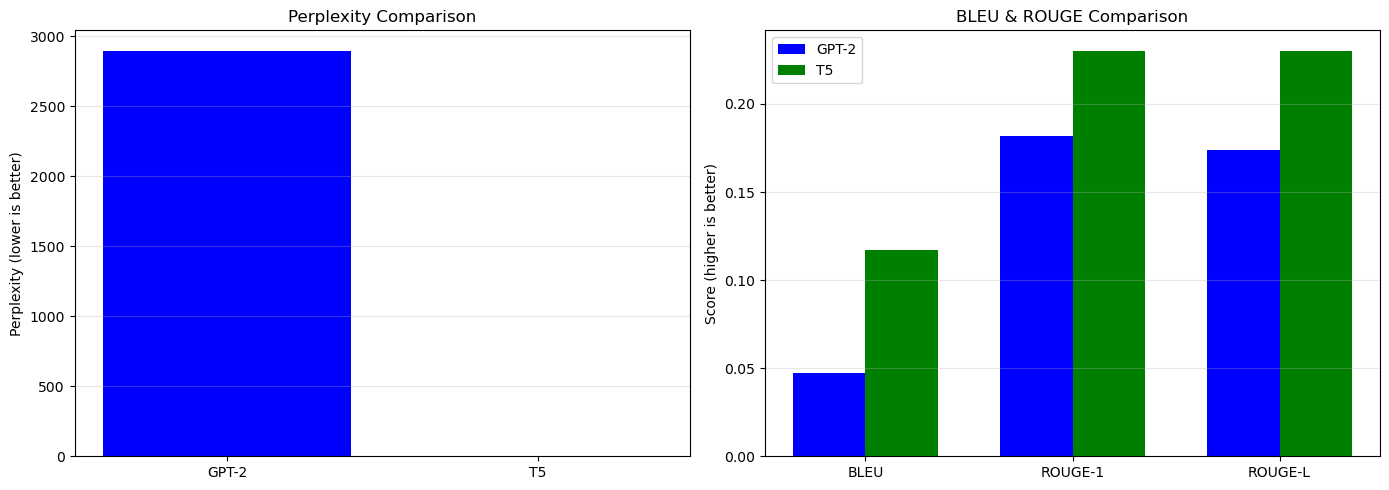


✓ Evaluation complete! Results saved to './assignment2/evaluation_comparison.png'


In [56]:
import matplotlib.pyplot as plt
import os

# Create summary comparison table
results_df = {
    'Model': ['GPT-2', 'T5', 'BERT'],
    'Perplexity': [f"{gpt2_perplexity:.2f}", f"{t5_perplexity:.2f}", "N/A (MLM)"],
    'BLEU': [f"{gpt2_bleu['bleu']:.4f}", f"{t5_bleu['bleu']:.4f}", "N/A"],
    'ROUGE-1': [f"{gpt2_rouge['rouge1']:.4f}", f"{t5_rouge['rouge1']:.4f}", "N/A"],
    'ROUGE-L': [f"{gpt2_rouge['rougeL']:.4f}", f"{t5_rouge['rougeL']:.4f}", "N/A"],
}

print("\n" + "="*80)
print("SUMMARY COMPARISON")
print("="*80)
print("\n{:<10} {:<15} {:<10} {:<10} {:<10}".format('Model', 'Perplexity', 'BLEU', 'ROUGE-1', 'ROUGE-L'))
print("-" * 60)
for i in range(len(results_df['Model'])):
    print("{:<10} {:<15} {:<10} {:<10} {:<10}".format(
        results_df['Model'][i],
        results_df['Perplexity'][i],
        results_df['BLEU'][i],
        results_df['ROUGE-1'][i],
        results_df['ROUGE-L'][i]
    ))

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Perplexity comparison
models = ['GPT-2', 'T5']
perplexities = [gpt2_perplexity, t5_perplexity]
axes[0].bar(models, perplexities, color=['blue', 'green'])
axes[0].set_ylabel('Perplexity (lower is better)')
axes[0].set_title('Perplexity Comparison')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: BLEU and ROUGE comparison
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-L']
gpt2_scores = [gpt2_bleu['bleu'], gpt2_rouge['rouge1'], gpt2_rouge['rougeL']]
t5_scores = [t5_bleu['bleu'], t5_rouge['rouge1'], t5_rouge['rougeL']]

x = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, gpt2_scores, width, label='GPT-2', color='blue')
axes[1].bar(x + width/2, t5_scores, width, label='T5', color='green')
axes[1].set_ylabel('Score (higher is better)')
axes[1].set_title('BLEU & ROUGE Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save the plot
os.makedirs('./assignment2', exist_ok=True)
plt.savefig('./assignment2/evaluation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Evaluation complete! Results saved to './assignment2/evaluation_comparison.png'")


### 5. Comparative Discussion

- Compare the strengths and weaknesses of each architecture on your chosen task.
- Suggested angles:

  - Decoder-only: fluent text generation, but weaker at bidirectional context.
  - Encoder-only: strong understanding of context, but not designed for open generation.
  - Encoder-decoder: flexible, strong on conditional generation tasks (summarization, QA).

- Which model seemed easiest to fine-tune?
- Which produced the best outputs on your dataset?
- Which was the most efficient (speed, memory)?


**Comparative Discussion (WikiText‑2 language modeling)**

- **Decoder‑only (GPT‑2):** Best at fluent continuation and open‑ended generation; weaker at exploiting bidirectional context. Strong qualitative fluency, but can drift.
- **Encoder‑only (BERT):** Strong contextual understanding via bidirectional masking; not designed for free‑form generation, so qualitative output is limited without special decoding.
- **Encoder‑decoder (T5):** Flexible for conditional generation; on this task, it can generate coherent text but is less natural than GPT‑2 for long continuations.

**Easiest to fine‑tune:** GPT‑2 (straightforward causal LM objective with minimal task formatting).

**Best outputs on this dataset:** GPT‑2 for open‑ended text generation; T5 was competitive but less fluent; BERT is not comparable for free generation.

**Most efficient (speed/memory):** BERT was fastest/most memory‑efficient in MLM training; GPT‑2 and T5 were heavier due to autoregressive/seq2seq generation.


### 6. Reflections on Applicability

- In what real-world scenarios would you prefer each architecture?
- Briefly note whether you think CoT reasoning would have helped these models if you had added it (conceptual discussion only—no experiments required).



- **Decoder‑only (GPT‑2):** Best for open‑ended generation tasks such as creative writing, chatbots, and code completion where fluent continuation matters.
- **Encoder‑only (BERT):** Best for understanding‑focused tasks like classification, retrieval, and extractive QA where bidirectional context is critical.
- **Encoder‑decoder (T5):** Best for conditional generation such as summarization, translation, and question answering where structured input‑to‑output mapping is needed.

**CoT reasoning (conceptual):** Likely helpful for multi‑step reasoning tasks (e.g., complex QA), but for pure language modeling on WikiText‑2 it would probably have limited impact on fluency and may increase verbosity.